# Project - Investigation of Seattle Airbnb Open Data
## by Chih-Chuan Ma

## Introduction

> Airbnb is one of the top resources to find a place to stay when I travel, and it is a unique and personalized resource for guests and travelers. Multiple types of properties in various regions can be selected, and travelers could look for a stay based on their requests. The datasets, as listed below, describe the listing activities of homestays, price and availability on days, and detail comments from reviewers in Airbnb of Seattle. <br>

> a. Listings, including full descriptions and average review score <br>
> b. Reviews, including unique id for each reviewer and detailed comments <br>
> c. Calendar, including listing id and the price and availability for that day <br>

> In this project, factors impacting price of homestays is analyzed and filtration of types of properties that have the better value of money will be discussed based on my personal preference. Score of reviews are revised as weighted average score according to the personal points of view for ratings. Besides, as a stranger to Seattle, I am curious which region and what season would be more expensive (or relatively cheap) to hire a place. Also, whether the score of review, amenities that I required, or any other factors would impact the price of stay? Thus, the relationship among region-related, review-related, and price of homestay would be analyzed.


## Data Wrangling

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# Load the dataset
df_listings = pd.read_csv('/Users/johnma/Desktop/Udacity_Data Scientist/Project 1/Seattle_airbnb/listings.csv')
df_reviews = pd.read_csv('/Users/johnma/Desktop/Udacity_Data Scientist/Project 1/Seattle_airbnb/reviews.csv')
df_calendar = pd.read_csv('/Users/johnma/Desktop/Udacity_Data Scientist/Project 1/Seattle_airbnb/calendar.csv')

In [3]:
## Explore the dimension of the orgin dataset
# Columns with url path should be removed since they are not necessary
# Identifiers such as 'id','scrape_id' and 'host_id' should be removed.
# Columns with lots of description including'name','summary','space','description','transit','zipcode','host_name','host_location','host_about','host_verifications' are not required
# Need to convert 'price' from string to float

print ('The dimension of the df_listings is', df_listings.shape)
print ('==============================')
print (df_listings.info())
print ('==============================')
print ('The dimension of the df_reviews is', df_listings.shape)
print ('==============================')
print (df_reviews.info())
print ('==============================')
print ('The dimension of the df_calendar is', df_calendar.shape)
print ('==============================')
print (df_calendar.info())


The dimension of the df_listings is (3818, 92)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit               

In [4]:
## Check null in all columns by percentage in df_listings
# The clolumns with missing values over 20% should be deleted.
# For columns with missing values below 20%, it would lead to a biased result if the average value is filled;
# as a result, rows with missing values would be removed.
#

null_percentage_listings = (df_listings.isnull().sum() / df_listings.shape[0]*100).round(2)
print(null_percentage_listings.sort_values(ascending=False).to_string());

license                             100.00
square_feet                          97.46
monthly_price                        60.27
security_deposit                     51.13
weekly_price                         47.38
notes                                42.06
neighborhood_overview                27.03
cleaning_fee                         26.98
transit                              24.46
host_about                           22.50
host_acceptance_rate                 20.25
review_scores_accuracy               17.23
review_scores_checkin                17.23
review_scores_value                  17.18
review_scores_location               17.16
review_scores_cleanliness            17.10
review_scores_communication          17.05
review_scores_rating                 16.95
last_review                          16.42
first_review                         16.42
reviews_per_month                    16.42
space                                14.90
host_response_rate                   13.70
host_respon

In [5]:
## Check varaibles with url path & identifiers. 'url' and 'id' are used as key word

value =['url','id']

for val in value:
    print (list (df_listings.columns[df_listings.columns.str.contains(val)]))

['listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url']
['id', 'scrape_id', 'host_id', 'host_identity_verified']


In [6]:
## Check null in all columns by percentage in df_reviews
# Rows with missing value should be removed

null_percentage_reviews = (df_reviews.isnull().sum() / df_reviews.shape[0]*100).round(2)
print(null_percentage_reviews.sort_values(ascending=False).to_string());

comments         0.02
listing_id       0.00
id               0.00
date             0.00
reviewer_id      0.00
reviewer_name    0.00


In [7]:
## Check null in all columns by percentage in df_calendar
# Missing value in price is because the rooms are available on those dates
# Since the percentage of missing value in 'price' is quite huge (over 30%), we should not replace null with the average price.
# Instead, I plan to remove rows with missing prices

null_percentage_calendar = (df_calendar.isnull().sum() / df_calendar.shape[0]*100).round(2)
print(null_percentage_calendar.sort_values(ascending=False).to_string());

price         32.94
listing_id     0.00
date           0.00
available      0.00


In [8]:
## Check variables with few items
# Variables including state, market, country code, country, names of jurisdiction could be removed since there is only one item
# In 'smart_location', eventhough the Chinese letters (西雅图, WA), 'seattle, wa' and 'Seattle , WA ' can be revised as 'Seattle, WA',
# this variable is basically represent the same city (Seattle). Thus, I would remove this column 
# 'smart_location' & 'city' are identical, the redundant column should be removed.

#Print frequency of categories
columns = ['state','market','smart_location','city','country_code','country',
           'jurisdiction_names','experiences_offered']

for col in columns:
    print ('\nFrequency of Categories for varible %s'%col)
    print (df_listings[col].value_counts())


Frequency of Categories for varible state
WA    3817
wa       1
Name: state, dtype: int64

Frequency of Categories for varible market
Seattle    3818
Name: market, dtype: int64

Frequency of Categories for varible smart_location
Seattle, WA                  3810
West Seattle, WA                2
Seattle , WA                    2
Ballard, Seattle, WA            1
西雅图, WA                         1
Phinney Ridge Seattle, WA       1
seattle, wa                     1
Name: smart_location, dtype: int64

Frequency of Categories for varible city
Seattle                  3810
West Seattle                2
Seattle                     2
Ballard, Seattle            1
西雅图                         1
Phinney Ridge Seattle       1
seattle                     1
Name: city, dtype: int64

Frequency of Categories for varible country_code
US    3818
Name: country_code, dtype: int64

Frequency of Categories for varible country
United States    3818
Name: country, dtype: int64

Frequency of Categories for va

In [9]:
## Check the amenities of all assests
# I would create a new column to store whether the assests equipt the amenities that are critical for myself -- Free parking, WIFI, and Kitchen

print (df_listings.amenities.sort_values)


<bound method Series.sort_values of 0       {TV,"Cable TV",Internet,"Wireless Internet","A...
1       {TV,Internet,"Wireless Internet",Kitchen,"Free...
2       {TV,"Cable TV",Internet,"Wireless Internet","A...
3       {Internet,"Wireless Internet",Kitchen,"Indoor ...
4       {TV,"Cable TV",Internet,"Wireless Internet",Ki...
                              ...                        
3813    {TV,"Cable TV",Internet,"Wireless Internet","A...
3814    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
3815    {"Cable TV","Wireless Internet",Kitchen,"Free ...
3816    {TV,"Wireless Internet",Kitchen,"Free Parking ...
3817    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, Length: 3818, dtype: object>


In [10]:
# Check is there duplications -- No duplicates are found
print (df_listings.duplicated().sum())
print (df_reviews.duplicated().sum())
print (df_calendar.duplicated().sum())

0
0
0


### Items of Data Wrangling

> 1. Remove unnecessary columns: <br>
   a. Columns with url path <br>
   b. Identifiers such as 'id','host_id', and 'scrape_id' <br>
  c.'name','summary','space','description','zipcode','host_name','host_location','host_about','host_verifications' are not required in the analysis
   d. Columns with identical content such as 'state', 'market', 'country code', 'country', 'names of jurisdiction', 'smart_location', 'experiences_offered ,and 'city' <br> 
> 2. Convert 'price' from string to float <br> 
> 3. Remove clolumns with more than one fourth of missing values <br> 
> 4. In both df_listings & df_reviews, columns with missing values below 20%, rows with missing values should be removed.<br> 
> 5. In df_calandar, remove rows with missing prices <br> 
> 6. Create a new column to reveal whether the hosts equipt the required amenities (Free Parking on Premises, Wireless Internet and Kitchen) <br> 
> 7. Create a new column showing the weighted average rating score <br> 


In [11]:
# Make a copy of original dataset
df_listings_clean = df_listings.copy()
df_reviews_clean = df_reviews.copy()
df_calendar_clean = df_calendar.copy()

In [12]:
# Convert 'price' from string to float

df_listings_clean['price'] = df_listings_clean['price'].str.replace('[\$,]', '', regex=True).astype(float)
df_calendar_clean['price'] = df_calendar_clean['price'].str.replace('[\$,]', '', regex=True).astype(float)


In [13]:
# Remove list of columns having more than 20% null

col_to_drop = null_percentage_listings[null_percentage_listings>20].keys()
df_listings_clean = df_listings_clean.drop(col_to_drop, axis=1)

null_percentage_clean = (df_listings_clean.isnull().sum() / df_listings_clean.shape[0]*100).round(2)
print(null_percentage_clean.sort_values(ascending=False).to_string());

review_scores_accuracy              17.23
review_scores_checkin               17.23
review_scores_value                 17.18
review_scores_location              17.16
review_scores_cleanliness           17.10
review_scores_communication         17.05
review_scores_rating                16.95
first_review                        16.42
last_review                         16.42
reviews_per_month                   16.42
space                               14.90
host_response_time                  13.70
host_response_rate                  13.70
neighbourhood                       10.90
medium_url                           8.38
xl_picture_url                       8.38
thumbnail_url                        8.38
host_neighbourhood                   7.86
summary                              4.64
bathrooms                            0.42
host_location                        0.21
zipcode                              0.18
bedrooms                             0.16
host_has_profile_pic              

In [14]:
# Remove columns with url path 

url_col = df_listings_clean.columns[df_listings_clean.columns.str.contains('url')]
df_listings_clean = df_listings_clean.drop(columns = url_col, axis=1)

# Remove unnecessary columns 

df_listings_clean = df_listings_clean.drop(columns = ['state','market','country_code', 'city', 'smart_location',
                                                      'country','jurisdiction_names','experiences_offered','id','host_id','scrape_id',
                                                     'zipcode','host_name','host_location',
                                                     'host_verifications','name','summary',
                                                      'space','description'], axis=1)

In [15]:
# Delete rows with missing values

for df in [df_listings_clean, df_reviews_clean, df_calendar_clean]:
    df.dropna(axis=0, inplace=True) # drop rows with missing value
    print (df.isna().sum().sort_values(ascending=False).to_string())# check whether the change is completed

last_scraped                        0
review_scores_rating                0
maximum_nights                      0
calendar_updated                    0
has_availability                    0
availability_30                     0
availability_60                     0
availability_90                     0
availability_365                    0
calendar_last_scraped               0
number_of_reviews                   0
first_review                        0
last_review                         0
review_scores_accuracy              0
host_since                          0
review_scores_cleanliness           0
review_scores_checkin               0
review_scores_communication         0
review_scores_location              0
review_scores_value                 0
requires_license                    0
instant_bookable                    0
cancellation_policy                 0
require_guest_profile_picture       0
require_guest_phone_verification    0
calculated_host_listings_count      0
minimum_nigh

In [16]:
# Check time span of the cleaned dataset
df_calendar_clean.date.min(), df_calendar_clean.date.max()

('2016-01-04', '2017-01-02')

In [17]:
# Check whether all words from 'targets' are present in sentence, and store the result (True or False) in 'required_amenities'

target = ['Wireless Internet', 'Free Parking on Premises', 'Kitchen']

df_listings_clean['required_amenities'] = df_listings_clean['amenities'].apply(lambda sentence: all(word in sentence for word in target))

# Drop 'amenities'
df_listings_clean = df_listings_clean.drop('amenities', axis=1)

# Check the result
print (df_listings_clean.required_amenities.head())


0    False
1     True
2     True
4    False
6    False
Name: required_amenities, dtype: bool


In [18]:
## Compute weighted rating score (weighted is listed below based on personal judgement)
# review_scores_rating * 100%
# review_scores_accuracy * 100%
# review_scores_cleanliness * 120%
# review_scores_checkin * 80%
# review_scores_communication * 80%
# review_scores_location * 50%
# review_scores_value * 120%

# Store the weighted review scores in 'review_scores_weighted'
df_listings_clean['review_scores_weighted'] = df_listings_clean.apply(lambda x: (x['review_scores_rating'] + x['review_scores_accuracy'] + x['review_scores_cleanliness']*1.2 + \
                                                                      x['review_scores_checkin']*0.8 + x['review_scores_communication'] * 0.8 + \
                                                                      x['review_scores_location'] * 0.5 + x['review_scores_value'] *1.2)/6,  axis=1).round(2)

# Drop the orignal review scores columns
df_listings_clean = df_listings_clean.drop(columns=['review_scores_rating','review_scores_accuracy', 
                                                    'review_scores_cleanliness','review_scores_checkin',
                                                    'review_scores_communication','review_scores_location',
                                                    'review_scores_value'])

# Check the transformation
df_listings_clean['review_scores_weighted'].head()


0    24.92
1    25.17
2    25.33
4    23.85
6    25.67
Name: review_scores_weighted, dtype: float64

In [19]:
print ('The dimension of the cleaned dataset is', df_listings_clean.shape)
print ('==============================')
print (df_listings_clean.info())
print ('==============================')
print (df_listings_clean.dtypes.to_string())

The dimension of the cleaned dataset is (2555, 48)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2555 entries, 0 to 3814
Data columns (total 48 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   last_scraped                      2555 non-null   object 
 1   host_since                        2555 non-null   object 
 2   host_response_time                2555 non-null   object 
 3   host_response_rate                2555 non-null   object 
 4   host_is_superhost                 2555 non-null   object 
 5   host_neighbourhood                2555 non-null   object 
 6   host_listings_count               2555 non-null   float64
 7   host_total_listings_count         2555 non-null   float64
 8   host_has_profile_pic              2555 non-null   object 
 9   host_identity_verified            2555 non-null   object 
 10  street                            2555 non-null   object 
 11  neighbourhood     

In [20]:
print (df_listings_clean.room_type.unique())
print ('====================================')
print (df_listings_clean['property_type'].unique())
print ('====================================')
print (df_listings_clean['bed_type'].unique())
print ('====================================')
print (df_listings_clean['host_response_time'].unique())
print ('====================================')
print (df_listings_clean['host_response_rate'].unique())
print ('====================================')
print (df_listings_clean['neighbourhood'].unique())

['Entire home/apt' 'Private room' 'Shared room']
['Apartment' 'House' 'Cabin' 'Camper/RV' 'Bungalow' 'Townhouse'
 'Condominium' 'Loft' 'Boat' 'Other' 'Dorm' 'Bed & Breakfast' 'Yurt'
 'Chalet' 'Tent' 'Treehouse']
['Real Bed' 'Futon' 'Pull-out Sofa' 'Airbed' 'Couch']
['within a few hours' 'within an hour' 'within a day' 'a few days or more']
['96%' '98%' '67%' '100%' '71%' '97%' '60%' '50%' '31%' '70%' '90%' '88%'
 '80%' '63%' '33%' '99%' '75%' '83%' '94%' '43%' '93%' '92%' '40%' '57%'
 '89%' '95%' '91%' '78%' '86%' '30%' '56%' '76%' '64%' '82%' '17%' '87%'
 '25%' '69%' '53%' '65%']
['Queen Anne' 'Ballard' 'Fremont' 'Lower Queen Anne' 'Westlake'
 'Wallingford' 'Green Lake' 'Minor' 'Madrona' 'Leschi'
 'University District' 'Roosevelt' 'Harrison/Denny-Blaine' 'Madison Park'
 'Atlantic' 'Pike Place Market' 'Central Business District' 'Pike Market'
 'Eastlake' 'Portage Bay' 'South Lake Union' 'Magnolia' 'Belltown'
 'International District' 'Yesler Terrace' 'First Hill' 'Capitol Hill'
 'Pione

### Overview of the dataset

> The datasets contain information of price from January of 2016 to January of 2017 (df_calendear) and listings with hosts with 92 columns and 3818 rows (df_listings). After data is wrangled, the dataset of listings has 48 variables with 2555 rows. As many as data is trying to be reserved, but columns over one fifth of missing values, and rows with NaN are removed since a biased result would be made if the average value is inserted. <br>

> I used to travel abroad a lot before the pandemic, and Airbnb is one of the top resources to find a place to stay. Among numerous luxurious ameninities, all I care is a convenient free parking space, speedy WIFI, and a kitchen. In addition, since a car will be hired when traveling in the USA, the location of the stay is not really important. However, the feedback of cleanliness and value of money from others is crucial for me. As a result, new columns including 'review_scores_weighted' and 'required_amenities' are created to help me to analyze the places I would probably look for.


### Q1: What is the most popular property type and which region does the most properties locate?

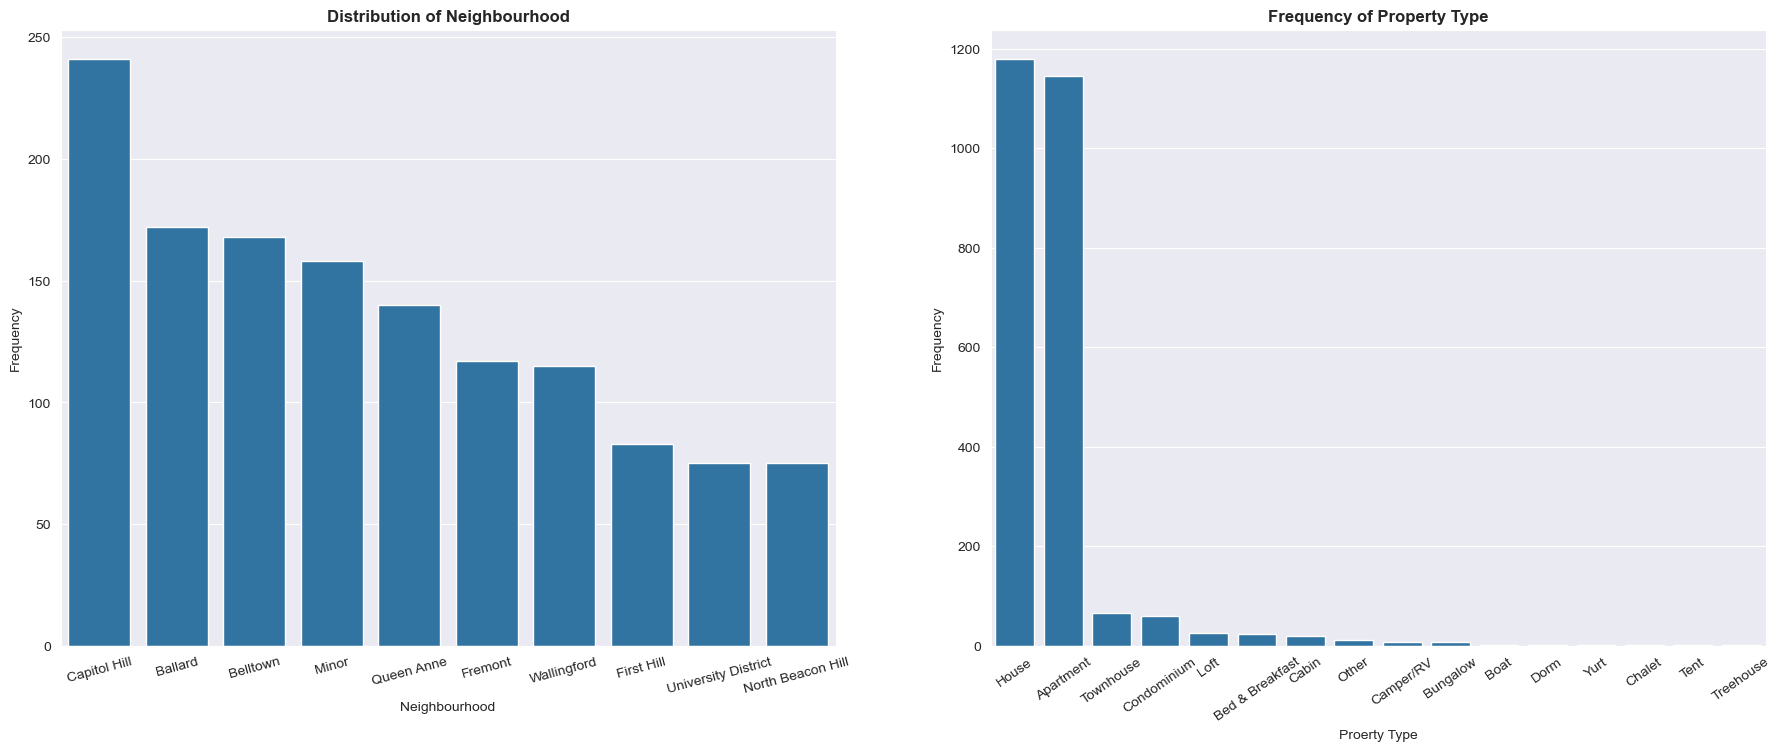

In [21]:
## Bar plot for borrower State and duration of loan term

plt.figure(figsize = [22, 8])
base_color = sb.color_palette()[0]
plt.subplots_adjust(hspace=0.5)
sb.set_theme({'axes.grid' : True})


plt.subplot(1, 2, 1)
order = df_listings_clean['neighbourhood'].value_counts().iloc[:10].index
sb.countplot (data=df_listings_clean, x='neighbourhood', 
              color=base_color, order = order)
plt.title('Distribution of Neighbourhood', weight='bold')
plt.xlabel('Neighbourhood')
plt.xticks(rotation=15)
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
order = df_listings_clean['property_type'].value_counts().index
sb.countplot (data=df_listings_clean, x='property_type', 
              color=base_color, order = order)
plt.title('Frequency of Property Type', weight='bold')
plt.xlabel('Proerty Type')
plt.xticks(rotation=35)
plt.ylabel('Frequency')
plt.show();

> The top 5 regions where the most properties offered are Capitol Hill, Ballard, Belltown, Minor and Queen Anne. Based on the plot above, house and apartment are the major type of property in Seattle.

### Q2: How much does it usually cost for a place to stay in Airbnb of Seattle? 

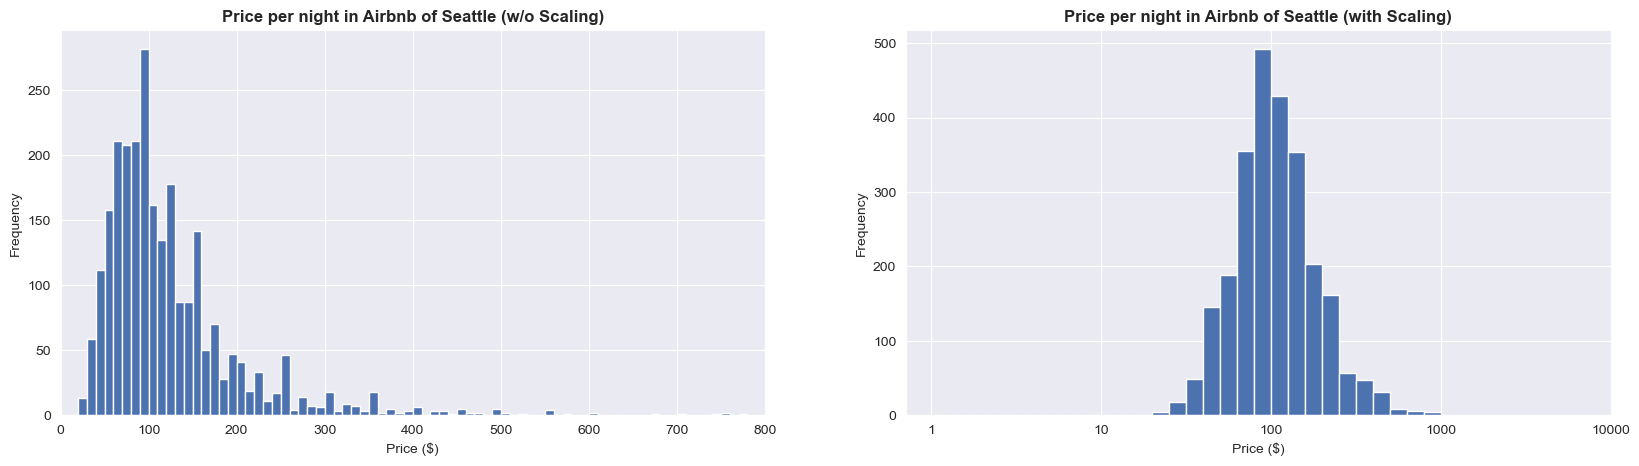

In [22]:
## HISTOGRAM on Left : price per night without scaling ##

plt.figure(figsize = [20, 5])
bins = np.arange(0, df_listings_clean['price'].max()+ 10, 10)
sb.set_theme({'axes.grid' : True})

plt.subplot(1, 2, 1)
plt.hist(data=df_listings_clean, x='price' , bins = bins)
plt.xlim([0, 800])
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Price per night in Airbnb of Seattle (w/o Scaling)', weight='bold')
sb.set_theme({'axes.grid' : True})


## HISTOGRAM on Right : price per night without scaling

plt.subplot(1, 2, 2)
log_binsize = 0.1
bins = 10** np.arange(0, np.log10(df_listings_clean['price'].max())+ log_binsize, log_binsize)

plt.hist(data = df_listings_clean, x = 'price', bins = bins)
plt.xscale('log')
plt.title('Price per night in Airbnb of Seattle (with Scaling)', weight='bold')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.xticks([10**0, 10**1, 10**2, 10**3, 10**4], [1, '10', '100','1000', '10000'])
plt.show();

> The plots demonstrate the distrubtion of prices per night in Airbnb of Seattle. The distribution of data without scaling reveals clearly right-skewed with a long tail. When the data of price is standardized, the distribution becomes genearlly bell-shaped, and most of the price of stay is between USD80 and USD120.

### Q3: How quick could I receive feedback from hosts if I raise questions? Which region has better or worse quality? 

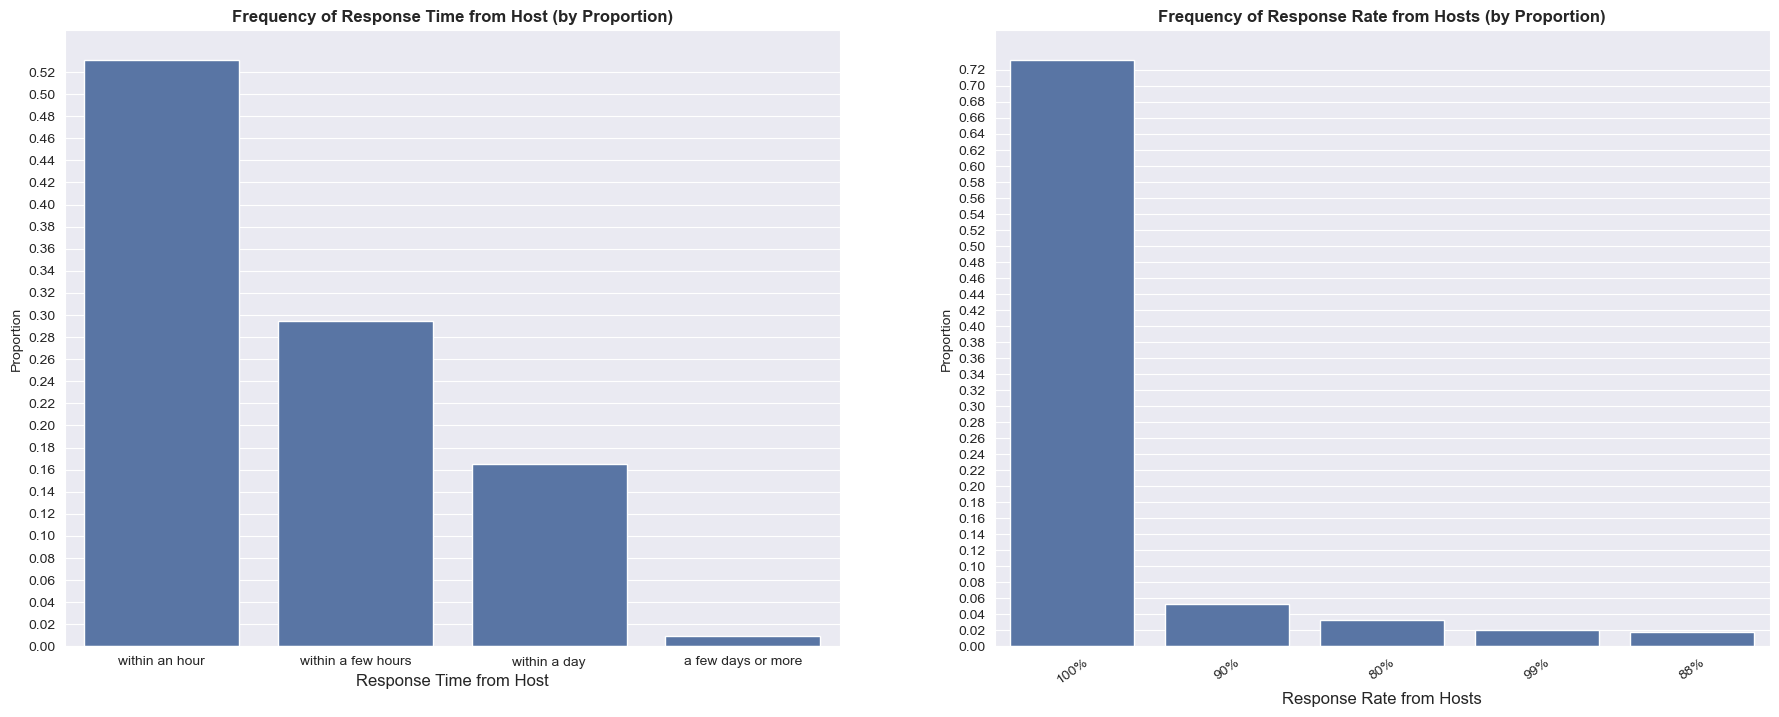

In [23]:
## Bar chart of response time from hosts ##

plt.figure(figsize = [22, 8])
base_color = sb.color_palette()[0]
plt.subplots_adjust(hspace=0.5)
sb.set_theme({'axes.grid' : True})


plt.subplot(1, 2, 1)
type_counts = df_listings_clean['host_response_time'].value_counts()
type_order = type_counts.index

n_estatus = df_listings_clean['host_response_time'].value_counts().sum()
max_type_count = type_counts[0]
max_prop = max_type_count / n_estatus


tick_props = np.arange(0, max_prop, 0.02)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

sb.countplot(data = df_listings_clean, x = 'host_response_time', 
             color = base_color, order = type_order)
plt.yticks(tick_props * n_estatus, tick_names)
plt.title('Frequency of Response Time from Host (by Proportion)', weight='bold')
plt.xlabel('Response Time from Host', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('Proportion')


## Bar chart of response rate from hosts ##

plt.subplot(1, 2, 2)
type_counts = df_listings_clean['host_response_rate'].value_counts(sort=True).iloc[:5]
type_order = type_counts.index

n_estatus = df_listings_clean['host_response_rate'].value_counts().sum()
max_type_count = type_counts[0]
max_prop = max_type_count / n_estatus


tick_props = np.arange(0, max_prop, 0.02)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

sb.countplot(data = df_listings_clean, x = 'host_response_rate', color = base_color, order = type_order)
plt.yticks(tick_props * n_estatus, tick_names)
plt.title('Frequency of Response Rate from Hosts (by Proportion)', weight='bold')
plt.xlabel('Response Rate from Hosts', fontsize=12)
plt.ylabel('Proportion')
plt.xticks(rotation=35)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show();

In [24]:
# Extract highest weighted review score from regions
high_scores = df_listings_clean.groupby('neighbourhood')['review_scores_weighted'].mean().sort_values(ascending=False).round(4).head(10)

# Extract lowest weighted review score from regions
low_scores = df_listings_clean.groupby('neighbourhood')['review_scores_weighted'].mean().sort_values(ascending=True).round(4).head(10)

print ('=========================')
print ('The average weighted review scores of all regions')
print (df_listings_clean['review_scores_weighted'].mean())
print ('=========================')
print ('States with highest weighted review scores')
print (high_scores)
print ('=========================')
print ('States with lowest weighted review scores')
print (low_scores)
print ('=========================')



The average weighted review scores of all regions
24.60120547945216
States with highest weighted review scores
neighbourhood
High Point               25.4529
Arbor Heights            25.3600
Riverview                25.3260
Harrison/Denny-Blaine    25.3000
Licton Springs           25.2350
Yesler Terrace           25.1909
Genesee                  25.1824
Gatewood                 25.1650
Holly Park               25.1567
Madrona                  25.1270
Name: review_scores_weighted, dtype: float64
States with lowest weighted review scores
neighbourhood
View Ridge             22.5150
Pinehurst              22.8050
University District    22.8595
South Park             22.9700
South Beacon Hill      23.4350
Interbay               23.8017
Ravenna                23.8419
Industrial District    24.0050
Eastlake               24.0438
Dunlap                 24.1143
Name: review_scores_weighted, dtype: float64


<Figure size 640x480 with 0 Axes>

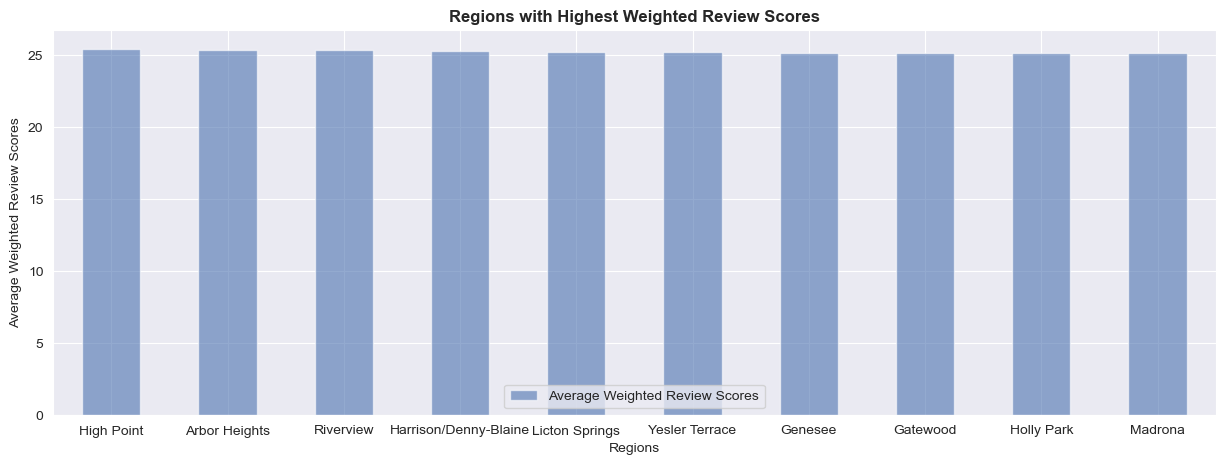

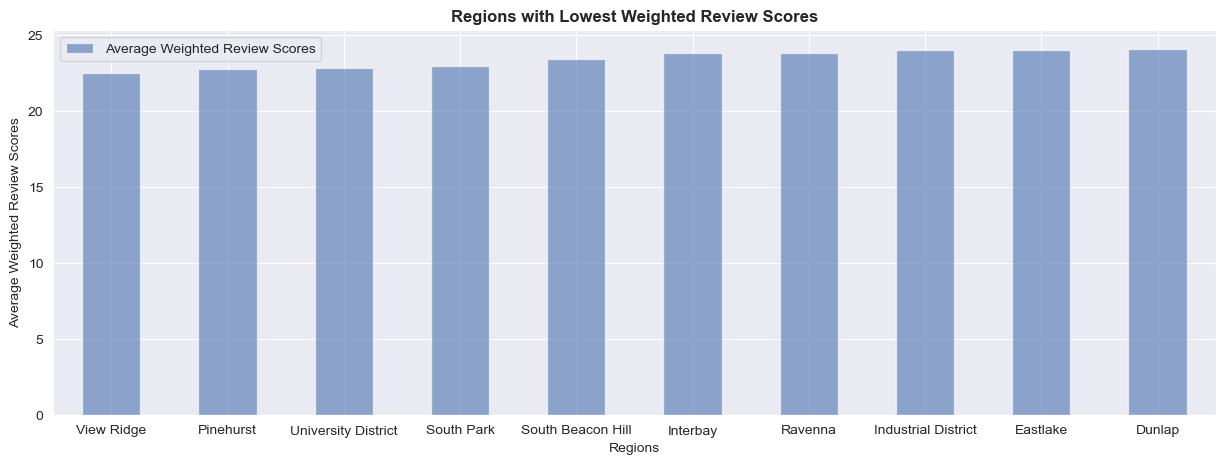

In [25]:
#Plot -- Regions with highest average weighted scores

plt.subplots_adjust(hspace=0.5)

df_high_scores_regions= pd.DataFrame(df_listings_clean.groupby('neighbourhood')['review_scores_weighted'].mean().sort_values(ascending=False).round(4).head(10))
df_high_scores_regions['neighbourhood'] = df_high_scores_regions.index

df_high_scores_regions.plot.bar(x="neighbourhood", y='review_scores_weighted',
                       color = base_color, alpha=0.6, figsize=[15,5])

plt.title('Regions with Highest Weighted Review Scores', weight='bold')
plt.xlabel('Regions')
plt.ylabel('Average Weighted Review Scores')
plt.xticks(rotation=360)
plt.legend(['Average Weighted Review Scores'], loc=0)
plt.show()

# Plot -- Regions with lowest average weighted scores

df_low_scores_regions= pd.DataFrame(df_listings_clean.groupby('neighbourhood')['review_scores_weighted'].mean().sort_values(ascending=True).round(4).head(10))
df_low_scores_regions['neighbourhood'] = df_low_scores_regions.index

df_low_scores_regions.plot.bar(x="neighbourhood", y='review_scores_weighted',
                       color = base_color, alpha=0.6, figsize=[15,5])
plt.title('Regions with Lowest Weighted Review Scores', weight='bold')
plt.xlabel('Regions')
plt.ylabel('Average Weighted Review Scores')
plt.xticks(rotation=360)
plt.legend(['Average Weighted Review Scores'], loc=0)
plt.show();

> 1. Generally speaking, feedback from hosts in Airbnb of Seattle is quite efficient. Usually quick reponses from hosts within an hour and a few hours should be expected, and hosts rarely ignore questions from customers.

> 2. As a family of four that cares about the quality of stay, regions such as Hight Point, Arbor Heights, Riverview, Harrison/Denny-Blaine and Licton Sprints should be investigated as higher priority due to the best average weighted reviews scores. On the contrary, areas including View Ridge, Pinehurst and University District should be avoided since the feedback from travelers is generally negative and the review scores are much lower than the average.

### Q4: It's also important to consider the safety, privacy and budget when traveling. Considering the price of stay and whether the host is verified, how much does the cost for a house or apartment contains the amenities I required in the regions with the best average feedback scores?

In [26]:
# Filter property type as "Apartment" and "House" in top 6 regions with highest weighted average scores

df_filter_high = df_listings_clean[(df_listings_clean['property_type'].isin(['Apartment','House'])) & 
                     (df_listings_clean['neighbourhood'].isin(['High Point','Arbor Heights','Riverview',
                                                               'Harrison/Denny-Blaine','Licton Springs',
                                                               'Yesler Terrace']))]


# Class function: filter the place I would prefer:
# Hourse or Apartment in good weighted score region with amenities I required


class PlaceIPrefer:
    def __init__(self, property_type=['House', 'Apartment'], neighbourhood = df_high_scores_regions.index,
                required_amenities = True):
        self.property_type = property_type
        self.neighbourhood = neighbourhood
        self.required_amenities = required_amenities

    @classmethod
    def load(cls, self):
        df = df_listings_clean.loc[df_listings_clean['property_type'].isin(self.property_type) & \
                                   df_listings_clean['neighbourhood'].isin(self.neighbourhood) & \
                                   df_listings_clean['required_amenities'].isin([self.required_amenities])]
        self.df = df
        
# Filter the places -- total 59 places I would consider

filter_place = PlaceIPrefer()
PlaceIPrefer.load(filter_place)
print(filter_place.df)

     last_scraped  host_since  host_response_time host_response_rate  \
610    2016-01-04  2013-03-04  within a few hours               100%   
641    2016-01-04  2015-08-05      within an hour               100%   
647    2016-01-04  2013-11-02  within a few hours                88%   
652    2016-01-04  2015-07-01      within an hour               100%   
656    2016-01-04  2012-04-02  within a few hours               100%   
658    2016-01-04  2012-08-07        within a day                75%   
659    2016-01-04  2012-11-13      within an hour               100%   
670    2016-01-04  2011-09-11      within an hour               100%   
672    2016-01-04  2015-04-29  within a few hours               100%   
675    2016-01-04  2014-08-29      within an hour               100%   
680    2016-01-04  2013-11-18      within an hour                80%   
684    2016-01-04  2014-11-13      within an hour               100%   
685    2016-01-04  2015-03-16  within a few hours               

<Figure size 2500x800 with 0 Axes>

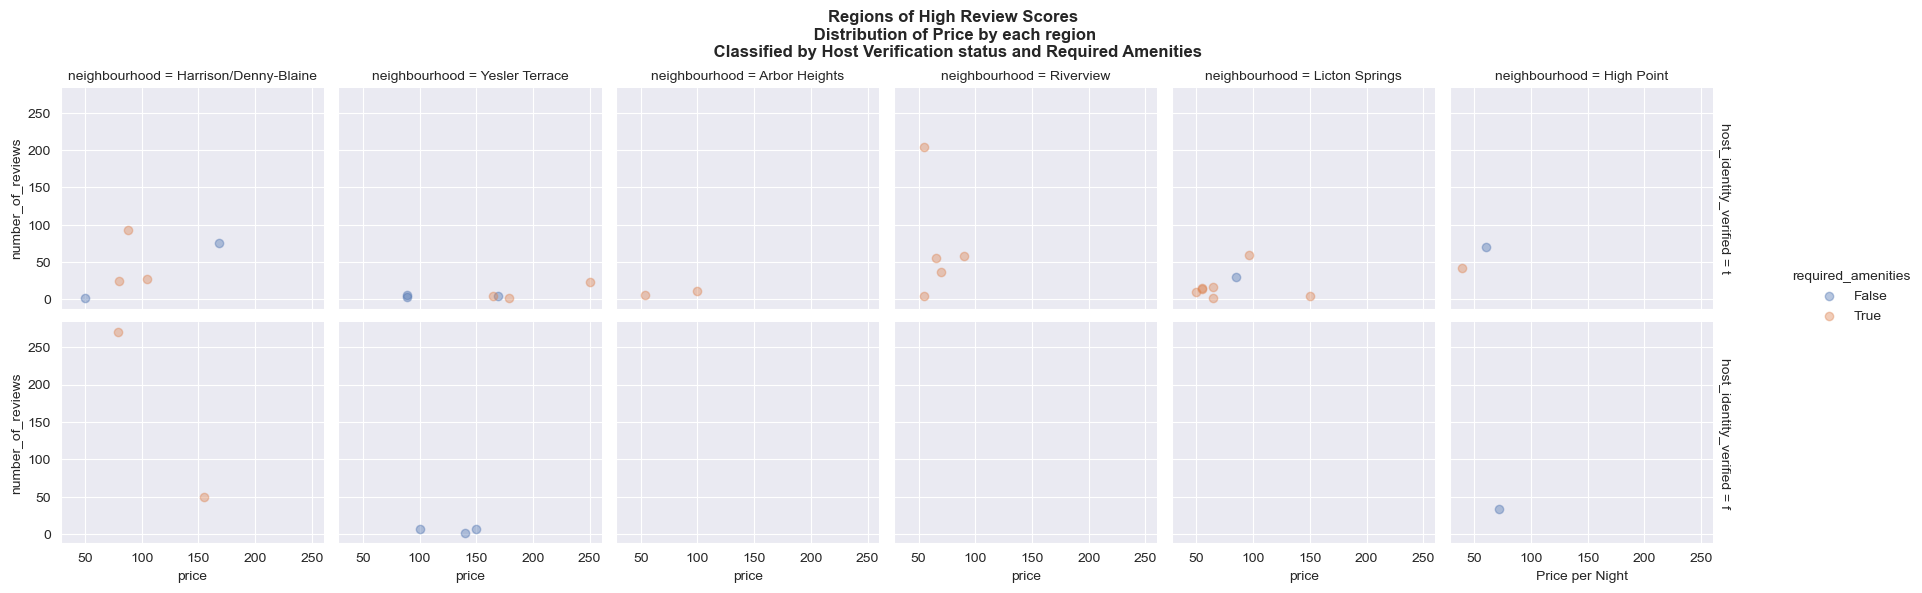

In [27]:
# Plot the place I would prefer

plt.figure(figsize = [25, 8])
g = sb.FacetGrid(data = df_filter_high, col = 'neighbourhood', row = 'host_identity_verified', 
                 hue = 'required_amenities', margin_titles = True)
g.map(plt.scatter, 'price','number_of_reviews', alpha=2/5)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Regions of High Review Scores \n Distribution of Price by each region \n Classified by Host Verification status and Required Amenities', 
               weight='bold')
plt.xlabel('Price per Night')
plt.ylabel('Number of Reviews ')
g.add_legend()

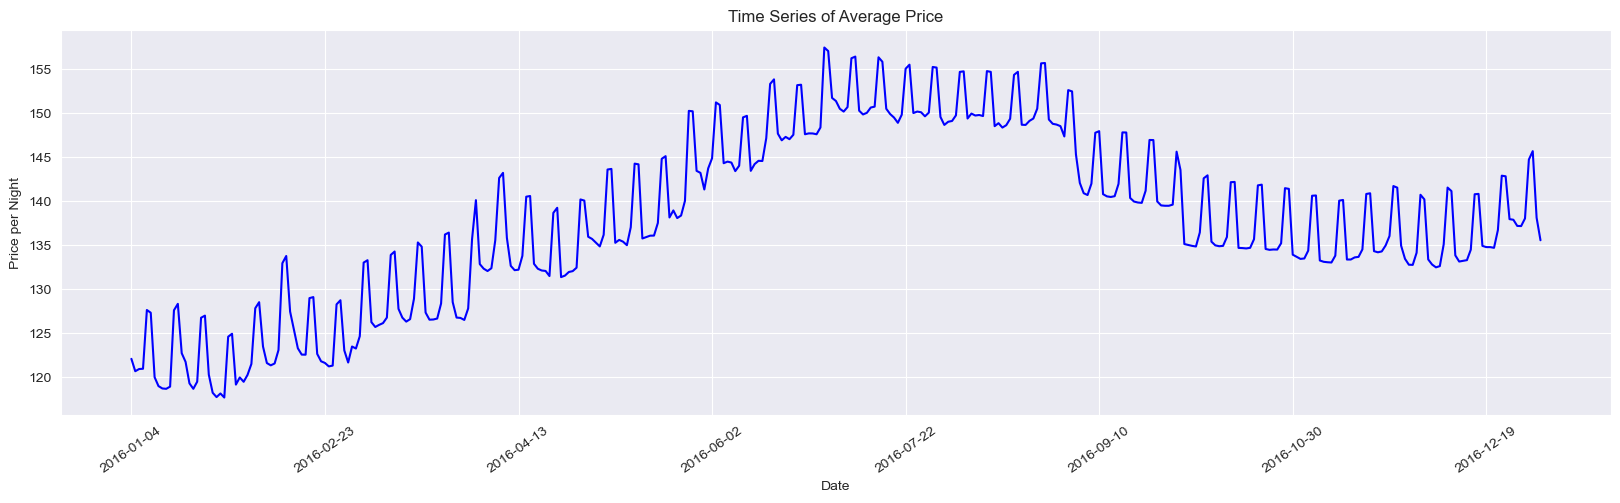

In [28]:
# To observe the trend of overall price by date, 
# property type of "House & Apartment" is not subset, and only consider the average price
# Thus, groupby by 'date' and take the mean price of all property type

df_calender_clean = df_calendar_clean.groupby('date', as_index=True)['price'].mean().round(2)

# Plot the trend of price by date

plt.figure(figsize = [20, 5])
df_calender_clean.plot(color="blue")

plt.title("Time Series of Average Price")
plt.xticks(rotation=35)
plt.xlabel('Date')
plt.ylabel('Price per Night')
plt.show()

> 1. Cleary the trend of price per night increased since January and reaches at the peak in summer. The highest average price in Airbnb in Seattle is from July until the end of August, reached at more than USD150 which increased around 30% compared to the price in January.

> 2. Take whether the host of property is verified, number of reviews, and price per night into consideration, Yesler Terrace has the highest average cost of a stay with the required amenities, at more than USD150. Other places, on the other hand, have the lower average price, ranging from USD50 and USD100.



### Q5: Which factors could impact price?

In [29]:
# Check the variables more correlated with 'price'

correlation = df_listings_clean.corr()['price'].abs().sort_values(ascending = False).iloc[:8]
print (correlation)

price                1.000000
accommodates         0.664604
bedrooms             0.637431
beds                 0.601112
bathrooms            0.518524
guests_included      0.434211
reviews_per_month    0.207529
number_of_reviews    0.131556
Name: price, dtype: float64


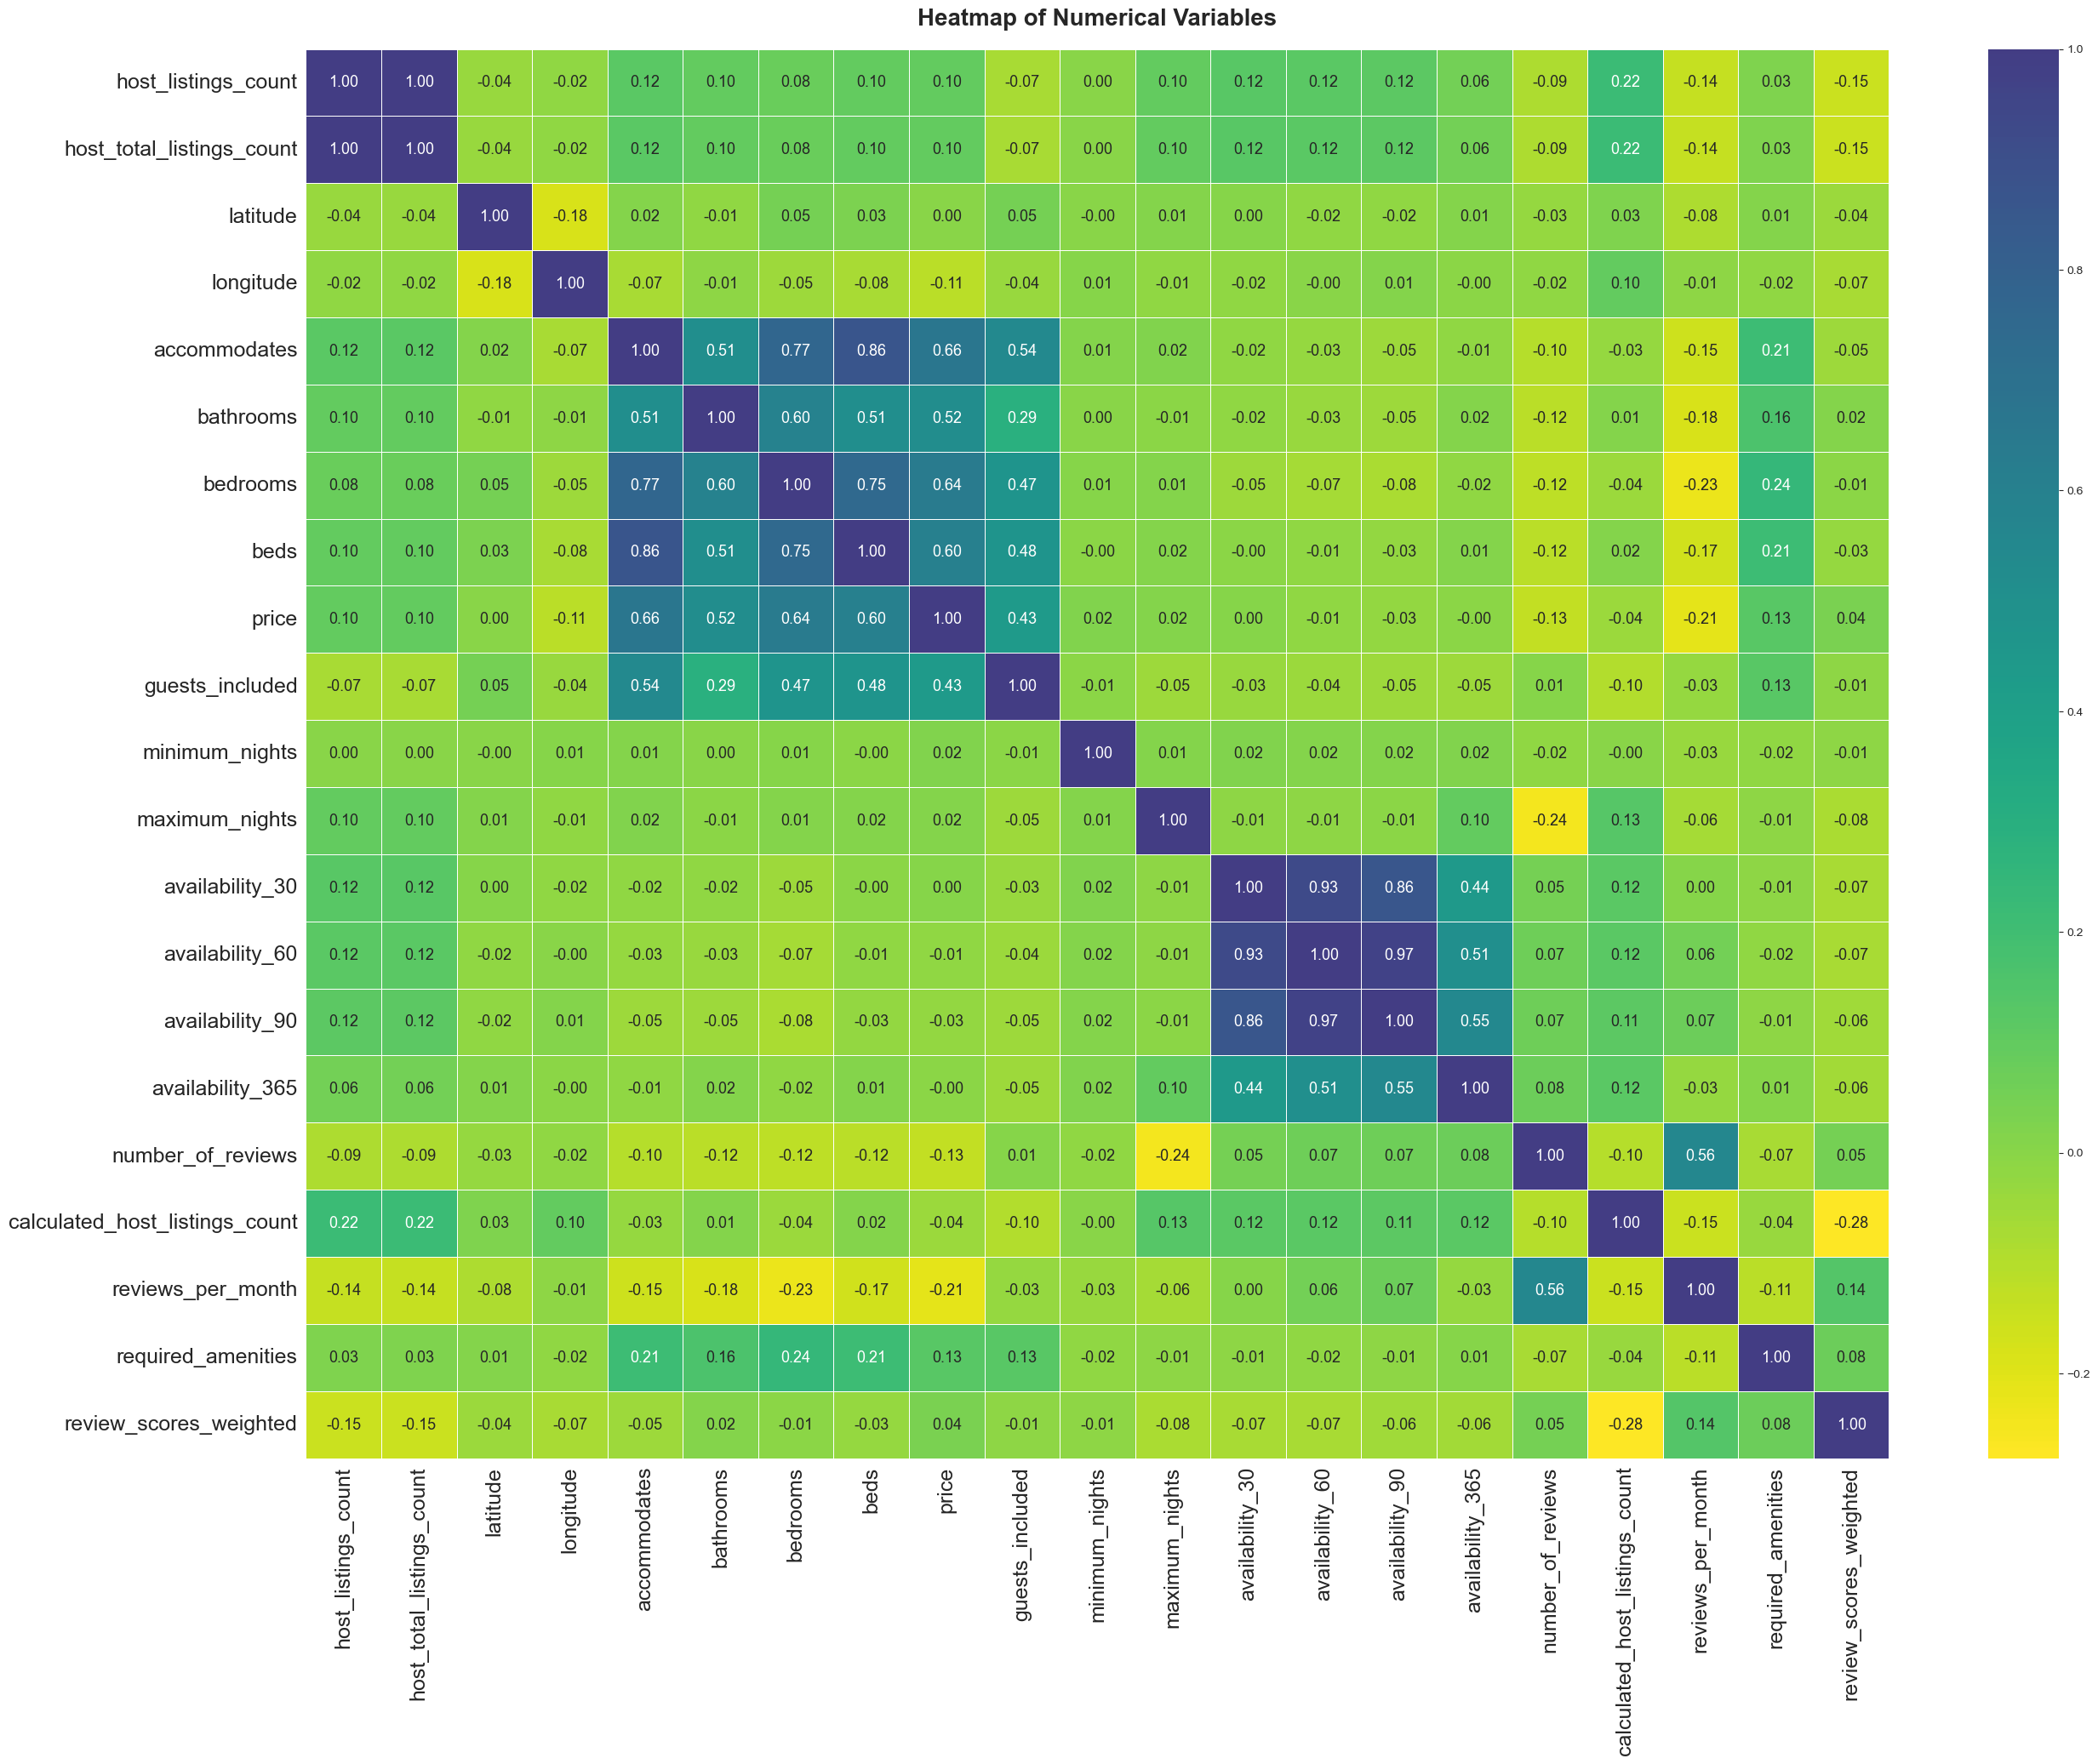

In [30]:
# Plot Heatmap for all numerical variables
# Overview of correlation among variables and APR

plt.figure(figsize=(30,24))
plt.subplots_adjust(top=0.8) 
sb.heatmap(df_listings_clean.corr(), annot=True, cmap='viridis_r', fmt='.2f', linewidths=0.5, 
           center=0.5, annot_kws = {'fontsize':13})

plt.title ('Heatmap of Numerical Variables', weight='bold', size=20, pad=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('heatmap.pdf')
plt.show();

In [31]:
# Select factors with higher correlation with 'price' as 'num_df_listings'

num_df_listings = df_listings_clean[['reviews_per_month','number_of_reviews',
                                    'guests_included','beds','bedrooms','bathrooms','accommodates','price']]

# Select categorical factors -- Boolean factors and variables with few items are selected as categorical items
cat_df_listings = df_listings_clean[['host_response_time','host_is_superhost','host_has_profile_pic',
                                    'host_identity_verified','neighbourhood','is_location_exact', 'property_type',
                                    'room_type','bed_type','cancellation_policy']]

# Concat above two datasets as 'new_df'
new_df = pd.concat([num_df_listings, pd.get_dummies(cat_df_listings, prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)]
                   , axis=1)

print(new_df.shape)

(2555, 125)


In [32]:
def clean_fit_linear_mod(df, response_col, test_size=.25, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train_scaled, X_test_scaled, y_train, y_test - output from sklearn train test split used for optimal model
    
    '''
    
    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    # Fit the scaling on the training & test set
    # Convert Feature/Column with Scaler
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    regressor = LinearRegression()
    lr = TransformedTargetRegressor(regressor=regressor, func=np.log, inverse_func=np.exp) # Instantiate
    
    lr.fit(X_train_scaled, y_train) #Fit
    
    #Predict using your model
    y_test_preds = lr.predict(X_test_scaled)
    y_train_preds = lr.predict(X_train_scaled)
    
    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
 

    return test_score, train_score, lr, X_train_scaled, X_test_scaled, y_train, y_test


# Fit the Function
test_score, train_score, lr, X_train_scaled, X_test_scaled, y_train, y_test = clean_fit_linear_mod(new_df, 'price', 
                                                                                     test_size=.3, rand_state=42)

print("The r-squared on the training data was {}, \
compared to that of test data was {} on {} values.".format(train_score.round(4), test_score.round(4), len(y_test)))



The r-squared on the training data was 0.634, compared to that of test data was 0.6838 on 767 values.


> 1. Based on the heatmap of numerical characters above, 'accommodates', 'bedrooms', and 'beds' show obvious positive correlation with the price of stay. Other factors including 'bathrooms', 'guests_included', and 'number_of_reviews' also reveal positive impact on price. Compared with other numerical variables, 'reviews_per_month' shows relatively stronger negative impact on price. In other words, property with more monthly reviews would be less expensive. 

> 2. Model of linear regression is selected in the project since the prediction of price can be linear with various variables. Theoretically, the price prediction could be done with proper data engineering from a dataset with independent and dependent variables.

> 3. The dataset of training model is combined by columns of numerical and categorical. By scaling the X_train, X_test data, and initiating linear regression model, around 68.38% of variables can be explained by the prediction of linear regression. Compared with the r-squared of 63.4% in training data, the r-squared of test data is a bit better.


## Conclusions

> The main interest of the project is to investigate characteristics influencing price of stay in Airbin of Seattle, and observe properties based on my persoan preference. By creating new factors to reveal whether properties equip the ameniteis I need and weighted review scores, those original columns can be removed and thus the overall variables are reduced. In addition, the redundant factors with same value (such as city and smart location) are deleted.

> The average cost of stay in Airbnb Seattle ranges from USD80 to USD120, and most properties locate in regions of Capital Hill, Ballard, Belltown, Minor and Queen Anne. The cost of accommodation varies a lot by different seasons. Obviously, the trend of price of stay increased from January and achieved yearly high in Summer, especially from July unitl the end of August. The gap of price difference could be more than 20% based on the data in 2016. Furthermore, the hosts in Airbnb Sealttle are very efficient. Most of the time, feedback from hosts could be received within couple of hours, and questions from customers are rarely ignored. 

> The criteria of further selection is based on my personal preference since I do care about ratings from other travelers, especially the comments of cleaningness and whether is it easy to park a car and kitchen is equiped. As a result, it's efficient to observe regions with higher weighted scores as higher priority, and places with more negative comments can ben avoided. Taking whether the host of property is verified, number of reviews, and price per night into consideration, Yesler Terrace has the highest average cost of a stay with the required amenities, at more than USD150. Other places meeting my criteria include High Point, Arbor Hieghts, Riverview, Harrison/Denny-Blaine , and Licton Springs could be my target areas since under the identical conditions, the stay can be cheaper, ranging from USD50 to USD100.

> In general, price of stay becomes more expensive while more accommodates, bedrooms, beds, bathrooms and guests are requested. Places with greater numbers of reviews are also more expensive; however, properties with more monthly reviews would be cheaper. The linear regression model is based on a revised dataset combining with numerical and categorical variables. while the training section is scaled, the r-squared of the prediction is 68.38% which is higher than 63.4% of training section.
 
> In summary, although the quotation and other variables in Airbnb of Seattle may differ nowadays, the analysis demonstrates an overview of Airbnb in Seattle, including the speed of host respond, the trend of homestays price, price of regions with better comments of quality, and factors impacting cost of stay. The investigation provides a good practice of efficiently filtering places locate in high quality regions with relatively reasonable budget, and avoid costly rooms with negative experience.
